# Distribution based outlier detection.

This notebook experiments with two distribution based approaches: Histogram Based Outlier Detection (HBOD) and Emprical Cumulative Distribution Outlier Detection (ECOD).

* HBOS works by treating every feature independently and looks at the sum of of the log-inverse-bin-heights across features to calculate the threshold. Two main parameters: 1) Bin Count, 2) Training Outlier Contamination %.
* ECOD is similar but uses the empiral percentiles rather than the histogram bin heights. It only requires one parameter: 1) Training Outlier Contamination %

This work is heavily based off of the following medium posts:

* HBOD: https://medium.com/dataman-in-ai/anomaly-detection-with-histogram-based-outlier-detection-hbo-bc10ef52f23f
* ECOD: https://medium.com/dataman-in-ai/handbook-of-anomaly-detection-with-python-outlier-detection-3-ecod-5cbf3e3021eb

Findings:

1. HBOD effective at finding outliers when the contamination is known and present in the training set.
2. HBOD is less effective when the training set is uncontaminated (recall = 60%, precision = 100%)
3. HBOS Using an ensemble approach based on bin count improves the accuracy when using uncontaminated training data: recall = 80%, precision = 100%.
4. ECOD arguably performed better on uncontaminated data: recall 100%, precision 93%. It performed slightly worse on contaminated data.


# Contaminated Training Data

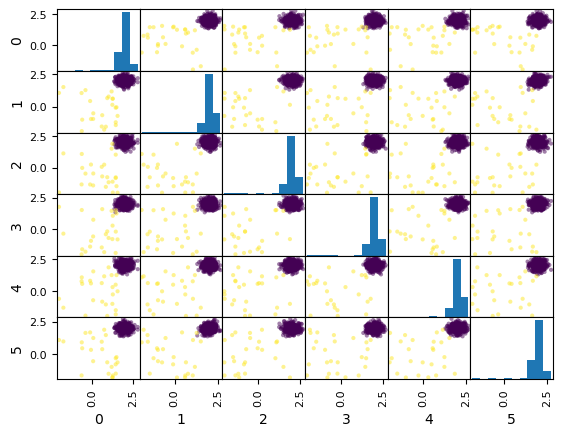

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

#plot the traing data, coloured by outlier
X_train_pd = pd.DataFrame(X_train)
pd.plotting.scatter_matrix(X_train_pd, c=y_train)
plt.show()
#plot first 5 rows of train
X_train_pd.head()

In [3]:
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

The threshold for the defined comtanimation rate: 5.563712646460526
The training data: {0: 475, 1: 25}
The test data: {0: 474, 1: 26}


In [4]:
threshold = hbos.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train, y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-1.28
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,16.02


In [5]:
descriptive_stat_threshold(X_test, y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,474,94.8,2.02,2.01,2.01,1.99,2.01,2.00,-1.05
1,Outlier,26,5.2,0.06,-0.43,-0.12,0.02,0.02,0.18,16.65


In [6]:
from sklearn.metrics import classification_report
print('train metrics:')
print(classification_report(y_train, y_train_pred))
print('test metrics:')
print(classification_report(y_test, y_test_pred))

train metrics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

test metrics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       0.96      1.00      0.98        25

    accuracy                           1.00       500
   macro avg       0.98      1.00      0.99       500
weighted avg       1.00      1.00      1.00       500



# Uncontaminated Training Data

In [9]:
# what if we don't have outliers in the train set
X_train_inliers = X_train[y_train == 0]
y_train_inliers = y_train[y_train == 0]

n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.005) # choose arbitrary small value for contamination
hbos.fit(X_train)

# Training data
y_train_inliers_scores = hbos.decision_function(X_train_inliers)
y_train_inliers_pred = hbos.predict(X_train_inliers)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_inliers_pred))
print("The test data:", count_stat(y_test_pred))

The threshold for the defined comtanimation rate: 17.33184305436724
The training data: {0: 475}
The test data: {0: 485, 1: 15}


In [8]:
# less able to find outliers when they do not appear in training set

print('test metrics:')
print(classification_report(y_test, y_test_pred))

test metrics:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       475
         1.0       1.00      0.60      0.75        25

    accuracy                           0.98       500
   macro avg       0.99      0.80      0.87       500
weighted avg       0.98      0.98      0.98       500



# Ensembling

In [12]:
# lets use ensemble methods based on bin count, this should add stabilty and circumvent the problem of hypertuning the bins parameter

k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]

def fit_ensemble(X, contamination):
    model_dict = dict()
    for k in k_list:
        hbos = HBOS(n_bins=k,contamination=contamination) # choose arbitrary small value for contamination
        hbos.fit(X)
        model_dict[k] = hbos
    return model_dict

def ensemble_predict(X, model_dict):
    # allocate memory
    n_models = len(model_dict)
    results = np.zeros((X.shape[0], n_models))
    for idx, k in enumerate(model_dict.keys()):
        results[:,idx] = model_dict[k].predict(X)
    return results.sum(axis=1) > n_models/2

# with contamination
models = fit_ensemble(X_train, 0.05)
y_test_pred = ensemble_predict(X_test, models)

print('test metrics with contamination:')
print(classification_report(y_test, y_test_pred))

# without contamination
# with contamination
models = fit_ensemble(X_train_inliers, 0.005)
y_test_pred = ensemble_predict(X_test, models)

print('test metrics without contamination:')
print(classification_report(y_test, y_test_pred))

test metrics with contamination:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

test metrics without contamination:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       475
         1.0       0.81      1.00      0.89        25

    accuracy                           0.99       500
   macro avg       0.90      0.99      0.94       500
weighted avg       0.99      0.99      0.99       500



# HBOD Conclusion

Fast, effective and simple method.

Ensembling showed a noticeable improvement when the training data is uncontaminated.

# ECOD: Empirical Cumalitive-Distribution Outlier Detection

In [20]:
from pyod.models.ecod import ECOD

# with contamination

ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_test_pred = ecod.predict(X_test)
print('test metrics with contamination:')
print('ECOD Threshold:', ecod.threshold_)
print(classification_report(y_test, y_test_pred))

# without
ecod = ECOD(contamination=0.005)
ecod.fit(X_train_inliers)
y_test_pred = ecod.predict(X_test)
print('test metrics without contamination:')
print('ECOD Threshold:', ecod.threshold_)
print(classification_report(y_test, y_test_pred))


test metrics with contamination:
ECOD Threshold: 16.320821760780653
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       0.93      1.00      0.96        25

    accuracy                           1.00       500
   macro avg       0.96      1.00      0.98       500
weighted avg       1.00      1.00      1.00       500

test metrics without contamination:
ECOD Threshold: 16.662292645056453
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       475
         1.0       0.93      1.00      0.96        25

    accuracy                           1.00       500
   macro avg       0.96      1.00      0.98       500
weighted avg       1.00      1.00      1.00       500

